# Imports

In [ ]:
# pip install datasets evaluate rouge_score peft sentence-transformers transformers sentencepiece

In [85]:
import time
from functools import partial

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
from peft import get_peft_model, LoraConfig, TaskType, PeftModel
from sentence_transformers import CrossEncoder
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    get_scheduler,
)

In [3]:
def set_seed(seed=42):
    """
    Sets seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = (
        True  # only applies to CUDA convolution operations
    )
    torch.backends.cudnn.benchmark = False


set_seed()

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Data

In [189]:
df1 = load_dataset("sberquad", split="train")#.train_test_split(test_size=0.2)
df2 = load_dataset('lmqg/qag_ruquad')

Generating test split: 100%|██████████| 23936/23936 [00:00<00:00, 87044.42 examples/s]


In [250]:
model_name = "distilbert-base-cased-distilled-squad" # "t5-small"

In [252]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.vocab_size, tokenizer.model_max_length

(28996, 512)

# Preprocessing

In [261]:
def tokenize_preprocess(examples):
    start_positions, end_positions, attention_masks, input_ids, sequence_ids = [], [], [], [], []
    for _, example in enumerate(tqdm(examples)):
        questions = [question.strip() for question in example["questions"]]
        answers = [answer.strip() for answer in example['answers']]
        context = example['paragraph'].strip()
        for i, answer in enumerate(answers):
            start_idx = context.lower().find(answer.lower())
            end_idx = start_idx + len(answer)
            
            if start_idx != -1 and end_idx <= 512:
                inputs = tokenizer(questions[i], context, max_length=512, truncation=True, padding="max_length")
                start_token = inputs.char_to_token(start_idx, sequence_index=1)
                end_token = inputs.char_to_token(end_idx-1, sequence_index=1)

                if start_token is not None and end_token is not None:
                    start_positions.append(start_token)
                    end_positions.append(end_token)
                    attention_masks.append(inputs['attention_mask'])
                    input_ids.append(inputs['input_ids'])
                    sequence_ids.append(inputs.sequence_ids(0))
                
    return start_positions, end_positions, attention_masks, input_ids, sequence_ids

In [259]:
def tokenize_preprocess_squad(examples):
    start_positions, end_positions, attention_masks, input_ids, sequence_ids = [], [], [], [], []
    for i, example in enumerate(tqdm(examples)):
        answer = example['answers']
        start_idx = answer['answer_start'][0]
        question = example['question'].strip()
        context = example['context'].strip()
        answer_text = answer['text'][0].strip()
        
        if start_idx == -1:
            start_idx = context.lower().find(answer_text.lower())
        end_idx = start_idx + len(answer_text)
        
        if start_idx != -1 and end_idx <= 512:
            inputs = tokenizer(question, context, max_length=512, truncation=True, padding="max_length")
            start_token = inputs.char_to_token(start_idx, sequence_index=1)
            end_token = inputs.char_to_token(end_idx-1, sequence_index=1)

            if start_token is not None and end_token is not None:
                start_positions.append(start_token)
                end_positions.append(end_token)
                attention_masks.append(inputs['attention_mask'])
                input_ids.append(inputs['input_ids'])
                sequence_ids.append(inputs.sequence_ids(0))
    
    return start_positions, end_positions, attention_masks, input_ids, sequence_ids

In [260]:
start_positions, end_positions, attention_masks, input_ids, sequence_ids = tokenize_preprocess_squad(df1)

100%|██████████| 45328/45328 [01:23<00:00, 541.57it/s]


In [262]:
for sub in ['train', 'test', 'validation']:
    start_positions2, end_positions2, attention_masks2, input_ids2, sequence_ids2 = tokenize_preprocess(df2[sub])
    start_positions.extend(start_positions2)
    end_positions.extend(end_positions2)
    attention_masks.extend(attention_masks2)
    input_ids.extend(input_ids2)
    sequence_ids.extend(sequence_ids2)

100%|██████████| 4079/4079 [00:09<00:00, 429.65it/s]


In [265]:
df_dict ={'input_ids': input_ids,
          'attention_mask': attention_masks,
          'start_positions': start_positions,
          'end_positions': end_positions,
          'sequence_ids': sequence_ids}

df = Dataset.from_dict(df_dict)
df.set_format(type='pt')
df = df.train_test_split(test_size=0.2)

In [268]:
# df.push_to_hub('Eka-Korn/distilbert-qa-russian', token=access_token)

Uploading the dataset shards:   0%|          | 0/1 [13:25<?, ?it/s]


KeyboardInterrupt: 

## Dataloading

In [269]:
BATCH_SIZE = 16

In [270]:
train_dataloader = DataLoader(
    df['train'], shuffle=True, batch_size=BATCH_SIZE
)

val_dataloader = DataLoader(
    df['test'], shuffle=True, batch_size=BATCH_SIZE
)

# Training setup

In [271]:
EPOCHS = 7

In [272]:
model = AutoModelForQuestionAnswering.from_pretrained(model_name).to(device)
model

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [273]:
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS,
    inference_mode=False,
    r=8,  # matrix rank
    lora_alpha=32,  # scaling factor (how important do we want our updated weights to be?)
    lora_dropout=0.1,
    target_modules=['q_lin', 'k_lin', 'v_lin', 'out_lin', 'lin1', 'lin2'],
    )

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 665,090 || all params: 65,857,540 || trainable%: 1.0099


In [309]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4) #1e-4

num_training_steps = EPOCHS * len(train_dataloader)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=len(train_dataloader) * 0.5,  # warmup = half an epoch
    num_training_steps=num_training_steps,
)

# Training

In [310]:
def train(model, train_dataloader, val_dataloader, device, optimizer, scheduler):
    train_losses = []
    val_losses = []

    model.train()

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch}, Learning rate: {scheduler.get_last_lr()[0]:.5f}")
        epoch_loss = []
        total_loss = 0
        for step, batch in enumerate(train_dataloader):
            start = time.time()
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            start_positions = batch["start_positions"].to(device)
            end_positions = batch["end_positions"].to(device)

            outputs = model(
                input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions,
            )

            # outputs has keys 'loss', 'start_logits', 'end_logits', 'encoder_last_hidden_state'
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            stop = time.time()

            if step % 400 == 0:  # note this will run on the first step also
                train_losses.append(loss.item())
                # Calculate validation loss on a single batch only for compute reasons
                val_batch = next(iter(val_dataloader))
                with torch.no_grad():
                    model.eval()
                    output = model(
                        val_batch["input_ids"].to(device),
                        attention_mask=val_batch["attention_mask"].to(device),
                        start_positions=val_batch["start_positions"].to(device),
                        end_positions=val_batch["end_positions"].to(device),
                    )
                    val_loss = output.loss
                    val_losses.append(val_loss.item())
                model.train()

                # Print statistics
                print(
                    f"Epoch: {epoch+1}/{EPOCHS} | Step: {step}/{len(train_dataloader)} | Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f} |",
                    f"LR: {scheduler.get_last_lr()[0]:.5f} | Time of Last Batch: {stop-start:.2f} \n",
                )

        avg_train_loss = total_loss / len(train_dataloader)
        epoch_loss.append(avg_train_loss)

        print(f"Epoch {epoch}, Train Loss: {avg_train_loss}")
    return train_losses, val_losses

In [311]:
train_losses, val_losses = train(model, train_dataloader, val_dataloader, device, optimizer, scheduler)

Epoch 0, Learning rate: 0.00000
Epoch: 1/7 | Step: 0/3597 | Train Loss: 1.89539 | Val Loss: 1.30024 | LR: 0.00000 | Time of Last Batch: 0.11 

Epoch: 1/7 | Step: 400/3597 | Train Loss: 2.22753 | Val Loss: 1.76236 | LR: 0.00007 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 800/3597 | Train Loss: 1.40808 | Val Loss: 2.40473 | LR: 0.00013 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 1200/3597 | Train Loss: 1.23773 | Val Loss: 1.53413 | LR: 0.00020 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 1600/3597 | Train Loss: 1.70205 | Val Loss: 1.42973 | LR: 0.00027 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 2000/3597 | Train Loss: 1.75550 | Val Loss: 1.75522 | LR: 0.00030 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 2400/3597 | Train Loss: 1.24091 | Val Loss: 1.37440 | LR: 0.00029 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 2800/3597 | Train Loss: 2.33093 | Val Loss: 1.41479 | LR: 0.00029 | Time of Last Batch: 0.10 

Epoch: 1/7 | Step: 3200/3597 | Train Loss: 0.81152 | Val Loss

In [315]:
model.save_pretrained("distillbert-qa-tuned-lora_1.01_v2")

In [316]:
model.push_to_hub('Eka-Korn/distillbert-qa-tuned-lora_1.01_v2', token=access_token)


adapter_model.safetensors:   0%|          | 0.00/2.67M [00:00<?, ?B/s]
adapter_model.safetensors: 100%|██████████| 2.67M/2.67M [00:01<00:00, 2.18MB/s][A


CommitInfo(commit_url='https://huggingface.co/Eka-Korn/distillbert-qa-tuned-lora_1.01_v2/commit/12e339847bff754d6a7a6182fb7e194e8efe5ec0', commit_message='Upload model', commit_description='', oid='12e339847bff754d6a7a6182fb7e194e8efe5ec0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Eka-Korn/distillbert-qa-tuned-lora_1.01_v2', endpoint='https://huggingface.co', repo_type='model', repo_id='Eka-Korn/distillbert-qa-tuned-lora_1.01_v2'), pr_revision=None, pr_num=None)

In [ ]:
# df.push_to_hub('Eka-Korn/distillbert-qa-russian', token=access_token)

## Plot losses

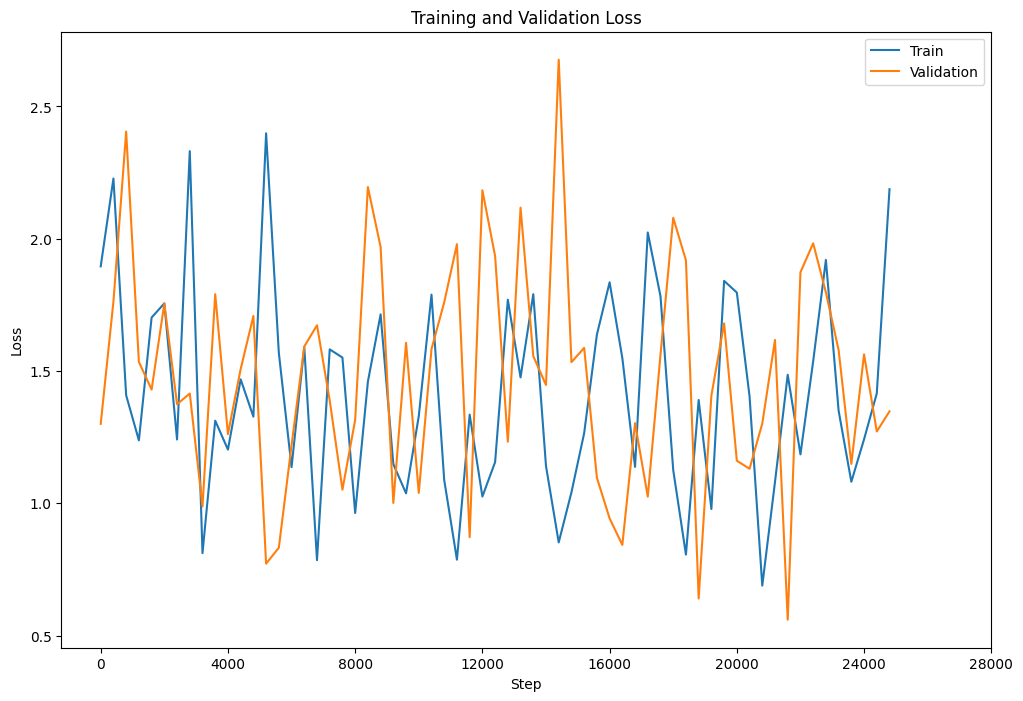

<Figure size 640x480 with 0 Axes>

In [317]:
plt.figure(figsize=(12, 8))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.xticks(
    ticks=plt.xticks()[0][1:], labels=400 * np.array(plt.xticks()[0][1:], dtype=int)
)  # steps * 400
plt.legend()
plt.show()
plt.savefig("loss2.png")

# Evaluation

In [328]:
# Hyperparameters:
n_best = 20  # number of start and end indices to consider as candidates (no need to check all 384 logits)
max_answer_len = 50  # max token length of a predicted answer

In [333]:
def retrieve_preds_and_labels(
    start_logits,
    end_logits,
    input_ids,
    seq_ids,
    start_pos=None,
    end_pos=None,
    n_best=n_best,
    max_answer_len=max_answer_len,
    inference=False,
):
    """
    Mapping helper function which post-processes and decodes fine-tuned T5ForQuestionAnswering model outputs
    as well as decoded ground truth labels.

    Inputs:
      -Start_logits and end_logits refer to the model output
      -Input_ids and seq_ids refer to the tokenized input
      -All are tensors of length `seq_len`
      -Start_pos and end_pos refer to the token indices of the ground truth labels if given and are tensors of length 1
      -n_best (int): Number of each of start and end indices to consider as candidates (no need to check all `seq_len` logits)
      -max_answer_len (int): Max token length of a predicted answer
      -inference (bool=True): If true, processes labels
    Returns:
      -Tuple of two lists, each of length batch_size
        -Decoded model predictions
        -Decoded ground truth labels
      -If inference=True, only the predictions are returned as a 1-tuple

    """
    assert (
        isinstance(n_best, int)
        and isinstance(max_answer_len, int)
        and n_best > 0
        and max_answer_len > 0
    )

    start_idx_list = np.argsort(start_logits.cpu().numpy())[-1 : (-n_best - 1) : -1]
    end_idx_list = np.argsort(end_logits.cpu().numpy())[-1 : (-n_best - 1) : -1]
    # requires cpu to use np.argsort and requires numpy for negative indexing
    # start_idx_list, end_idx_list are lists of length `n_best`. Now we check all n_best^2 combinations
    
    valid_answers = []
    for start_idx in start_idx_list:
        for end_idx in end_idx_list:
            # Ignore out-of-scope answers (i.e. indices of predicted answer is outside the context)
            if (seq_ids[start_idx].item() != 1 or seq_ids[end_idx].item() != 1):
                continue
            # Ignore answers with negative length or > max_answer_len
            if start_idx > end_idx or end_idx - start_idx + 1 > max_answer_len:
                continue

            # If this start end index pair survives it's valid
            # we sum the start and end logits
            valid_answers.append(
                {
                    "score": start_logits[start_idx] + end_logits[end_idx],
                    "start_idx": start_idx,
                    "end_idx": end_idx,
                }
            )
    # take prediction with max score, only decode this prediction (no need to decode all candidates)
    final_preds = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
    final_decoded_preds = tokenizer.decode(
        input_ids[final_preds["start_idx"] : (final_preds["end_idx"] + 1)]
    )

    # Now decode ground truth labels
    if not inference:
        labels = tokenizer.decode(input_ids[start_pos : (end_pos + 1)])
        return final_decoded_preds, labels
    else:
        return (final_decoded_preds,)

In [330]:
def postprocess(batch, output, inference=False, **kwargs):
    """
    Postprocesses and decodes model output (and ground truth labels if any).

    Inputs;
      -batch: The data batch returned from the DataLoader
      -output: Output of the model when given `batch`
      -inference (bool=False): Indicates if labels are available and decodes + returns them if so
    Returns:
      -2-tuple of numpy arrays of length `batch_size` indicating the model predictions and the ground truth labels respectively
      -Note: If set to inference mode (i.e. no labels), only the predictions are returned, and not in 1-tuple form.
    """

    # batch size used
    b_size = batch["input_ids"].size(0)

    # prepare map function with fixed inference and keyword arguments
    mapfunc = partial(retrieve_preds_and_labels, inference=inference, **kwargs)

    # if inference, no start/end positions, and we initialize placeholder tensors
    if inference:
        start_pos, end_pos = torch.empty((b_size, 1)), torch.empty((b_size, 1))
    else:
        start_pos, end_pos = batch["start_positions"], batch["end_positions"]

    # map helper function
    postprocessed_output = list(
        map(
            mapfunc,
            output.start_logits,
            output.end_logits,
            batch["input_ids"],
            batch["sequence_ids"],
            start_pos,
            end_pos,
        )
    )

    # output shape above: list of length `batch_size` of 2-tuples (pred, label) or 1-tuple (pred, )

    preds = np.array([postprocessed_output[i][0] for i in range(b_size)])
    if not inference:
        labels = np.array([postprocessed_output[i][1] for i in range(b_size)])
        return preds, labels
    else:
        return preds

## Evaluation metrics

In [321]:
def normalization(text):
    """
    Normalizes a given text by fixing whitespaces, converting to lowercase, and removing punctuation.
    This function does not remove stopwords, articles, or translate numbers to words as these actions
    can affect the length of the strings and thus the F-1 score.

    Input:
        -text (str): Text string to be normalized
    Returns:
        -The normalized text string
    """
    # Fix whitespaces, convert lowercase
    text = " ".join(text.split()).lower()

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    return text

### Exact match

In [322]:
def exact_match(preds, labels):
    """
    Calculates the exact match score between predictions and labels.
    Normalizes the predictions and labels first, then computes the proportion of equality between normalized predictions and labels.

    Input:
        -preds (np.array): Array of prediction strings
        -labels (np.array): Array of label strings
    Returns:
        -Exact match score (float) between the normalized predictions and labels

    """
    # Normalize predictions and labels
    preds = np.vectorize(normalization)(preds)
    labels = np.vectorize(normalization)(labels)

    return np.mean(preds == labels)

### F-1 score

In [323]:
def f1(preds, labels):
    """
    Computes F-1 score word-level.

    Input:
        -preds (np.array): Array of prediction strings
        -labels (np.array): Array of label strings
    Returns:
        -Mean F-1 score (float) for all pairs of normalized predictions and labels
    """

    f1_list = []

    # Normalize predictions and labels
    preds = np.vectorize(normalization)(preds)
    labels = np.vectorize(normalization)(labels)

    # Calculates F-1 Score for each pair of preds & labels
    for i in range(len(preds)):
        pred_tokens = preds[i].split()
        act_tokens = labels[i].split()

        common_tokens = set(pred_tokens) & set(act_tokens)
        if len(common_tokens) == 0:
            f1_list.append(0)
        else:
            pre = len(common_tokens) / len(pred_tokens)
            rec = len(common_tokens) / len(act_tokens)
            f1 = 2 * (pre * rec) / (pre + rec)
            f1_list.append(f1)

    return np.mean(f1_list)

### NLG metrics (BLEU, ROUGE, METEOR)

We will simply load these in from HuggingFace's *evaluate* library.

### Semantic Answer Similarity (SAS)
Idea: Feed the two sentences to a BERT-model fine-tuned for semantic textual similarity (STS) (specifically on the STS Benchmark dataset) and retrieve its similarity score.

In [324]:
def sas(cross_encoder, preds, labels):
    """
    Computes Semantic Answer Similarity (SAS) scores between predictions and labels via a cross-encoder.

    Input:
        -cross_encoder: Cross-encoder model used for prediction
        -preds (np.array): Array of prediction strings
        -labels (np.array): Array of label strings
    Returns:
        -Mean SAS score (float) for all prediction-label pairs

    """
    cross_encoder_input = [(preds[i], labels[i]) for i in range(len(preds))]
    sas_scores = cross_encoder.predict(cross_encoder_input)

    return sas_scores.mean()

### Evaluate model performance

In [331]:
def eval_acc(model, val_dataloader):
    """
    Evaluates the accuracy of a model on the validation dataset using various metrics:
      -EM, F1, METEOR, ROUGE-1, ROUGE-2, ROUGE-L, and SAS

    Input:
        -model: Model to be evaluated
        -val_dataloader: Data loader for the validation dataset
    Returns:
        -A dictionary containing the mean accuracy scores for each metric
    """

    # Setting up the evaluation metrics
    meteor = evaluate.load("meteor")
    rouge = evaluate.load("rouge")
    bleu = evaluate.load("bleu")
    cross_encoder = CrossEncoder("cross-encoder/stsb-roberta-large")

    # Put the model into evaluation mode
    model.eval()

    # Initialize lists to store accuracy scores
    em_list = []
    f1_list = []
    meteor_list = []
    rouge_1_list, rouge_2_list, rouge_L_list = [], [], []
    bleu_list = []
    sas_list = []

    # Evaluate model
    with torch.no_grad():
        print("Evaluating Validation Accuracies:")
        for batch in tqdm(val_dataloader):
            output = model(
                batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                start_positions=batch["start_positions"].to(device),
                end_positions=batch["end_positions"].to(device),
            )

            preds, labels = postprocess(
                batch, output, inference=False, n_best=n_best, max_answer_len=max_answer_len
            )

            # Compute accuracy
            em_val = exact_match(preds, labels)
            f1_val = f1(preds, labels)
            meteor_val = meteor.compute(predictions=preds, references=labels)["meteor"]

            rouge_val = rouge.compute(predictions=preds, references=labels)
            rouge_1 = rouge_val["rouge1"]
            rouge_2 = rouge_val["rouge2"]
            rouge_L = rouge_val["rougeL"]

            bleu_val = bleu.compute(predictions=preds, references=labels)["bleu"]
            sas_val = sas(cross_encoder, preds, labels)

            # Append accuracy scores to the corresponding lists
            em_list.append(em_val)
            f1_list.append(f1_val)
            meteor_list.append(meteor_val)
            rouge_1_list.append(rouge_1)
            rouge_2_list.append(rouge_2)
            rouge_L_list.append(rouge_L)
            bleu_list.append(bleu_val)
            sas_list.append(sas_val)

    # Compute and print average accuracy scores
    em_score = np.mean(em_list)
    f1_score = np.mean(f1_list)
    meteor_score = np.mean(meteor_list)
    rouge_1_score = np.mean(rouge_1_list)
    rouge_2_score = np.mean(rouge_2_list)
    rouge_L_score = np.mean(rouge_L_list)
    bleu_score = np.mean(bleu_list)
    sas_score = np.mean(sas_list)

    print(f"\n\nExact Match: {em_score}")
    print(f"F1: {f1_score}")
    print(f"METEOR: {meteor_score}")
    print(f"ROUGE-1: {rouge_1_score}")
    print(f"ROUGE-2: {rouge_2_score}")
    print(f"ROUGE-L: {rouge_L_score}")
    print(f"BLEU: {bleu_score}")
    print(f"SAS: {sas_score}")

    metrics_dict = {
        "EM": em_score,
        "F1": f1_score,
        "METEOR": meteor_score,
        "ROUGE-1": rouge_1_score,
        "ROUGE-2": rouge_2_score,
        "ROUGE-L": rouge_L_score,
        "BLEU": bleu_score,
        "SAS": sas_score,
    }

    return metrics_dict

In [334]:
metrics_dict = eval_acc(model, val_dataloader)

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Evaluating Validation Accuracies:



100%|██████████| 900/900 [27:54<00:00,  1.86s/it]



Exact Match: 0.5160648148148148
F1: 0.7232768099092667
METEOR: 0.6431945091247689
ROUGE-1: 0.20780888564002598
ROUGE-2: 0.062372584931408466
ROUGE-L: 0.2077774151814722
BLEU: 0.5557907061973886
SAS: 0.8044404983520508


In [335]:
metrics_dict

{'EM': 0.5160648148148148,
 'F1': 0.7232768099092667,
 'METEOR': 0.6431945091247689,
 'ROUGE-1': 0.20780888564002598,
 'ROUGE-2': 0.062372584931408466,
 'ROUGE-L': 0.2077774151814722,
 'BLEU': 0.5557907061973886,
 'SAS': 0.8044405}